# Modelo de clasificación binaria para la detección de xenofobia en tweets de migración

### Librerias útiles

##### Hugging Face
Se trata de una comunidad y plataforma de ciencia de datos que ofrece una gran cantidad de herramientas para la creación y evaluación de modelos de aprendizaje profundo. Entre ellas destacan [[Omer Mahmood @ Towards Data Science](https://towardsdatascience.com/whats-hugging-face-122f4e7eb11a#:~:text=Hugging%20Face%20is%20a%20community,(OS)%20code%20and%20technologies.)]:
* Herramientas que permiten a los usuarios construir, entrenar y desplegar modelos basados en código abierto
* Un lugar donde una amplia comunidad de científicos de datos, ingenieros de aprendizaje profundo e investigadores pueden reunirse para compartir ideas, obtener apoyo, contribuir a los proyectos e incluso compartir sus modelos entrenados o puros.

<figure>
    <img src="./assets/images/hug.png"
         alt="Hugging Face logo">
    <figcaption>Hugging Face logo</figcaption>
</figure>

No se encontró ningún modelo entrenado para la tarea de interés, por lo que se entrenaron y probaron 12 modelos a modo de seleccionar el mejor de ellos. La selección de estos 12 modelos consistió en tomar aquellos que estuviesen entrenados para una tarea similar a la xenofobia (en este caso fue el discurso de odio) y/o que hayan sido entrenados para comprender el idioma español.

De este estudio el modelo seleccionado fue [RoBERTuito-base-uncased](https://arxiv.org/abs/2111.09453)

##### PyTorch
Es una librería de aprendizaje automático de código abierto *que acelera el camino desde la creación de prototipos de investigación hasta el despliegue de producción [[PyTorch](https://pytorch.org/)].*

<figure>
    <img src="./assets/images/pytorch.png"
         alt="PyTorch logo">
    <figcaption>PyTorch logo</figcaption>
</figure>

Algunos de los modelos disponibles en Hugging Face se encuentran implementados sobre esta librería. De este modo, algunas de las herramientas disponibles en PyTorch son fácilmente adaptables con Hugging Face, esto nos permitirá añadir o modificar la estructura de una red neuronal, así como su comportamiento, permitiendo al usuario implementar varias funciones personalizadas.

##### Scikit learn
Se trata de una librería de código abierto enfocada en proveer herramientas de aprendizaje de máquinas tales como modelos estadísticos y matemáticos, así como métricas de evaluación comunes en algoritmos de aprendizaje de máquinas.
<figure>
    <img src="./assets/images/scikit.png"
         alt="scikit-learn logo"
         style="max-width: 20%; height: auto">
    <figcaption>scikit-learn logo</figcaption>
</figure>

Esta librería nos permitirá implementar de manera sencilla las métricas de evaluación del modelo de interés.

In [33]:
#Imports

#HuggingFace library
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, Trainer, TrainingArguments, TextClassificationPipeline
from datasets import Dataset, Value, ClassLabel, Features

#PyTorch Neural Networks
import torch
import torch.nn as nn

#data reading
import pandas as pd

#math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#scikit-learn metrics
from sklearn.metrics import (
    confusion_matrix, recall_score, accuracy_score, recall_score, precision_score, f1_score, classification_report
)

### Cargando el modelo preentrenado

Para usar cualquier modelo transformer de la biblioteca Hugging Face, se debe importar la clase `AutoModelForSequenceClassification` de la biblioteca `transformers`. Esta clase se encarga de cargar el modelo preentrenado y de configurar la capa de clasificación para la tarea de clasificación de secuencias. Además debe conocerse el nombre del modelo que se desea cargar, en este caso se usará el modelo `robertuito-base-uncased` que se encuentra disponible en la [biblioteca Hugging Face](https://huggingface.co/models).

La búsqueda de los modelos preentrenados se hace por lo regular a través del tipo de tarea a resolver la siguiente imagen muestra algunas tareas en hugging face.

<img src="./assets/images/hug_tasks.png"
         alt="Algunas tareas en hugging face"
         style="width: auto; height: 60%">

Al seleccionar la tarea de interés, la página muestra los modelos disponibles como en la siguiente imagen.

<img src="./assets/images/hug_models.png"
         alt="Algunos modelos disponibles"
         style="width: auto; height: 60%">

En caso de conocerse el nombre del modelo o bien el nombre del autor, se puede buscar directamente en la barra de búsqueda.

<img src="./assets/images/hug_search.png"
         alt="busqueda por auutor o nombre"
         style="width: auto; height: 60%">

Como ya se mencionó se realizó la búsqueda y entrenamiento de 12 modelos relacionados con el discurso de odio en español o modelos preentrenados en español. El modelo seleccionado fue `pysentimiento/robertuito-base-uncased`. Para cargarlo se usa la clase `AutoModelForSequenceClassification` de la biblioteca `transformers` a la cual se le pasa como parámetro el nombre del modelo y la cantidad de etiquetas a utilizar (en este caso fueron 2 xenofóbico y no xenofóbico).

También debe cargarse el tokenizador que se usó para entrenar originalmente el modelo. Un tokenizador es un algoritmo que divide un texto en unidades más pequeñas, llamadas tokens. Los tokenizadores son necesarios para que los modelos de lenguaje puedan procesar texto.

In [2]:
#set model name
model_name = "pysentimiento/robertuito-base-uncased"
#download model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=2)

#Load tokenizer
#Un tokenizer es un objeto que convierte una secuencia de caracteres en una secuencia de números.
#es una especie de filtro que prepara el texto para que el modelo lo pueda entender.
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at pysentimiento/robertuito-base-uncased were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.

### Configurando el modelo

Para agregar los tokens especiales como @usuario, url, etc agregados en el notebook anterior, se debe configurar el tokenizador para que reconozca estos tokens. Esto se realiza con la función `add_tokens` de la clase `AutoTokenizer` la cual recibe como parámetros una lista con los tokens especiales que se desean agregar. La documentación de esta función solicita que después de haber agregardo los tokens especiales se debe redimensionar el tokenizador, esto se hace con la función `resize_token_embeddings`.

Puesto que el modelo fue entrenado para aceptar una longitud máxima de 128 tokens, se debe configurar el tokenizador para que acepte esta longitud máxima. Esto se hace con la función `model_max_length`.

Finalmente se puede mapear las etiquetas a cadenas de texto, lo cual se realiza al modificar los atributos del modelo `id2label` y `label2id`. Si bien esta funcionalidad no es necesaria para realizar el entrenamiento, es útil para poder interpretar los resultados del modelo al momento de inferir conjuntos de texto pequeños.

In [3]:
#Config model: assign names to each label
model.config.id2label = {0: 'ok', 1:'hateful'}
id2label = {0: 'ok', 1:'hateful'}
model.config.label2id = {v:k for k,v in id2label.items()}

#Add special tokens to the tokenizer
tokenizer.add_tokens(['@usuario', 'url', 'hashtag', 'emoji'])
model.resize_token_embeddings(len(tokenizer))
tokenizer.model_max_length = 128

### Lectura de datos procesados

Para proceder a entrenar el modelo se debe procesar el conjunto de datos. Para esto primero se debe leer el conjunto de datos procesados en el notebook anterior. Para esto se usa la función `read_csv` de la biblioteca `pandas` la cual recibe como parámetro el nombre del archivo csv que contiene los datos procesados.

In [3]:
data_train = pd.read_csv('./assets/data/train.csv')
data_test = pd.read_csv('./assets/data/test.csv')
data_valid = pd.read_csv('./assets/data/valid.csv')
#una muestra aleatoria de los datos
data_train.sample(n=5, random_state=2022)

,id,text,date,label
4670,1256373527420317696,"@usuario señor presidente, que más hace falta ...",2021-09-06,0
373,1348643518563155968,Y TAMBIÉN LOS MIGRANTES ¡¡ ILEGALES !! url,2021-11-30,1
1164,1388760443087466496,@usuario @usuario Sabia usted que por toda la ...,2021-10-13,0
4178,1087215634075799552,"@usuario @usuario No dijo salgan a golpear, a ...",2021-11-17,0
2928,1393254552145641472,emoji ojos emoji Te invitamos a conocer esta i...,2021-08-26,0


Una vez cargados los datos se debe mapear el texto a sus respectivos tokens y a su vez mapear las etiquetas a sus respectivos valores numéricos. Con esto se obtiene un conjunto de datos listo para ser utilizado en el entrenamiento, validación y/o prueba del modelo. La siguiente celda de código muestra como se realiza este proceso.

In [4]:
def tokenize(batch):
        """Tokenize text in current mini batch. This is a util function for get_dataset_from_dataframes function

        Args:
            batch (batched datasets.arrow_dataset.Dataset)
        
        Returns:
            [datasets.arrow_dataset.Dataset]: Mapped text-label dataset
        """
        return tokenizer(batch['text'], padding=False, truncation=True)

def format_dataset(dataset):
    """Map text-label for specific dataset from pandas. This is a util function for get_dataset_from_dataframes function

    Args:
        dataset (datasets.arrow_dataset.Dataset): Dataset from pandas DataFrame

    Returns:
        [datasets.arrow_dataset.Dataset]: Mapped text-label dataset
    """
    def get_labels(examples):
        return {'labels': examples['label']}

    dataset = dataset.map(get_labels)
    return dataset

#Features to map insto dataset
features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=2, names=['ok', 'hateful'])
    })

train_dataset = Dataset.from_pandas(data_train, features=features)
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=4)
train_dataset = format_dataset(train_dataset)

test_dataset = Dataset.from_pandas(data_test, features=features)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=4)
test_dataset = format_dataset(test_dataset)

valid_dataset = Dataset.from_pandas(data_valid, features=features)
valid_dataset = valid_dataset.map(tokenize, batched=True, batch_size=4)
valid_dataset = format_dataset(valid_dataset)

#what happened?
#train_dataset[8290]
#tokenizer.decode(np.random.randint(0, 30002, size=20).tolist())


  0%|          | 0/1750 [00:00<?, ?ba/s]

0ex [00:00, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ba/s]

0ex [00:00, ?ex/s]

  0%|          | 0/250 [00:00<?, ?ba/s]

0ex [00:00, ?ex/s]

Para tener la posibilidad de usar un entrenamiento por lotes (pasar más de un texto a la vez al modelo) se debe instanciar un objeto DataCollatorWithPadding de la biblioteca transformers. Este objeto se encarga de agregar los tokens de relleno necesarios para que todos los textos tengan la misma longitud. La longitud máxima de los textos se obtiene de la función `model_max_length` de la clase `AutoTokenizer`.

In [5]:
#to be able to use batched training, we need to use a data collator
data_collator = DataCollatorWithPadding(tokenizer, padding='longest')

### Métricas de evaluación
Las métricas de evaluación o clasificación son medidas que permiten cuantificar la calidad de un modelo de clasificación, existe una gran variedad de ellas. Las más populares son: Precisión, Exahustividad, Valor-F, Exactitud y la matriz de confusión.

Para entender cada una de estas es necesario comprender los conceptos de falso positivo, falso negativo, verdadero positivo y verdadero negativo en la clasificación binaria. Consideremos dos posibles clases $+$ y $-$, y una muestra con una etiqueta real $ER$ y una predicción $P$ dada por el modelo a evaluar, con esto decimos que:

* Si la etiqueta real y la predicción coinciden y corresponde a la clase $+$, entonces el modelo ha predicho un verdadero positivo (VP)
* Si la etiqueta real y la predicción coinciden y corresponde a la clase $-$, entonces el modelo ha predicho un verdadero negativo (VN)
* Si la etiqueta real es de clase $+$ y la predicción es de clase $-$, es decir $ER \neq P$, el modelo ha predicho un falso negativo (FN)
* Si la etiqueta real es de clase $-$ y la predicción es de clase $+$, es decir $ER \neq P$, el modelo ha predicho un falso positivo (FN)

##### Precisión
La métrica de precisión es una medida de cuántas de las observaciones el modelo predijo correctamente sobre el total de las predicciones correctas e incorrectas. Para calcular la precisión se usa la siguiente ecuación.
$$precision = \frac{VP}{VP+FP}$$

##### Exhaustividad
La Exhaustividad es la medida de cuántas observaciones predijo correctamente el modelo sobre la cantidad total de las observaciones y se obtiene usando la ecuación
$$exhaustividad = \frac{VP}{VP+FN}$$

##### Valor-F
El Valor-F es una métrica que combina la precisión y la exhaustividad, a modo que se establece un equilibrio entre ambas métricas. Para calcularlo es necesario conocer los valores de precisión, exhaustividad y aplicar la ecuación
$$Valor F = 2\cdot \frac{precision \cdot exhaustividad}{precision + exhaustividad}$$

##### Exactitud
La exactitud mide el porcentaje de casos que el modelo ha predicho correctamente. Esta métrica tiende a sobre estimar el rendimiento del modelo cuando se utiliza un conjunto de prueba o validación desbalanceados y se calcula a través de la siguiente ecuación.
$$exactitud = \frac{VP+VN}{VP+VN+FP+FN}$$

##### Matriz de confusión
Para el caso de la clasificación binaria, la matriz de confusión es una tabla con los valores de VP, VN, FP y FN en función de las etiquetas reales y de las predicciones totales del conjunto de prueba o validación. La composición se muestra a continuación

<figure>
    <img src="./assets/images/matriz_confusion.png"
         alt="Matriz de confusión"
         style="width: auto height: 50%">
    <figcaption>Estructura general de la matriz de confusión para clasificación binaria</figcaption>
</figure>

En la siguiente celda de código se crea una función que recibe como parámetros las etiquetas reales y las predicciones del modelo y retorna los valores de VP, VN, FP y FN. Esta función será muy útil para calcular las métricas de evaluación por cada época.

In [6]:
def compute_metrics(p):
    """Compute Accuracy, Precision, Recall and F1 metrics

    Args:
        p ([List]): List with calculated logits by model and real label per sample

    Returns:
        [dict]: dict with calculated metrics
    """
    pred, labels = p
    #Get class with most probability
    pred = np.argmax(pred, axis=-1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    #Binary recall for class 0 (not xenophobic) and class 1 (xenophobic)
    recall_cls0 = recall_score(y_true=labels, y_pred=pred, pos_label=0, average='binary')
    recall_cls1 = recall_score(y_true=labels, y_pred=pred, pos_label=1, average='binary')
    #Binary precision for class 0 and class 1
    precision_cls0 = precision_score(y_true=labels, y_pred=pred, pos_label=0, average='binary')
    precision_cls1 = precision_score(y_true=labels, y_pred=pred, pos_label=1, average='binary')
    #Binary F1 for class 0 and class 1
    f1_cls0 = f1_score(y_true=labels, y_pred=pred, pos_label=0, average='binary')
    f1_cls1 = f1_score(y_true=labels, y_pred=pred, pos_label=1, average='binary')

    #F1 scores: macro (balanced data), micro and weighted (unbalanced data)
    f1_micro = f1_score(y_true=labels, y_pred=pred, average='micro')
    f1_macro = f1_score(y_true=labels, y_pred=pred, average='macro')
    f1_weight = f1_score(y_true=labels, y_pred=pred, average='weighted')

    return {'accuracy': accuracy, 'precision_cls1': precision_cls1, 'precision_cls0': precision_cls0,
            'recall_cls1': recall_cls1, 'recall_cls0': recall_cls0, 'f1_cls1': f1_cls1, 'f1_cls0': f1_cls0,
            'f1_micro': f1_micro, 'f1_macro': f1_macro, 'f1_weigth': f1_weight}

### Entrenamiento del modelo

Para entrenar el modelo se debe instanciar un objeto de la clase `Trainer` de la biblioteca transformers. Este objeto recibe como parámetros el modelo a entrenar, el conjunto de datos de entrenamiento, el conjunto de datos de validación, la función de evaluación y el DataCollatorWithPadding.

A través de la clase TrainingArguments es posible indicar al modelo cuántas épocas será entrenado, el tamaño del lote, la frecuencia de evaluación, el directorio donde se almacenarán los checkpoints, entre otros.

In [7]:
training_args = TrainingArguments(
        output_dir = './',
        num_train_epochs = 3,
        per_device_train_batch_size = 4,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        do_eval=True,
        logging_dir='./logs',
        load_best_model_at_end=True,
        bf16 = False,
        half_precision_backend = 'amp',
        greater_is_better = True
    )

In [8]:
trainer_args = {
        'model': model,
        'args': training_args,
        'train_dataset': train_dataset,
        'eval_dataset': valid_dataset,
        'data_collator': data_collator,
        'tokenizer': tokenizer,
        'compute_metrics': compute_metrics
    }

Una vez instanciada y configurada la clase Trainer, se procede a entrenar el modelo con el método `train()`. Por cada época se evalúa el modelo con el conjunto de datos de validación y se almacenan los checkpoints en el directorio indicado en la configuración de la clase TrainingArguments. El resultado de la evaluación se mostrará como una tabla.

In [10]:
trainer = Trainer(**trainer_args)
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7000
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 5250
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a 

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cls1,Precision Cls0,Recall Cls1,Recall Cls0,F1 Cls1,F1 Cls0,F1 Micro,F1 Macro,F1 Weigth
1,0.468800,0.420858,0.880000,0.786127,0.899637,0.621005,0.952625,0.693878,0.925373,0.880000,0.809625,0.874676
2,0.225200,0.744285,0.870000,0.834586,0.875433,0.506849,0.971831,0.630682,0.921117,0.870000,0.775899,0.857511
3,0.044500,0.728876,0.883000,0.765625,0.910891,0.671233,0.942382,0.715328,0.926369,0.883000,0.820849,0.880151


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./checkpoint-1750
Configuration saved in ./checkpoint-1750/config.json
Model weights saved in ./checkpoint-1750/pytorch_model.bin
tokenizer config file saved in ./checkpoint-1750/tokenizer_config.json
Special tokens file saved in ./checkpoint-1750/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./chec

TrainOutput(global_step=5250, training_loss=0.23647104081653414, metrics={'train_runtime': 188.9331, 'train_samples_per_second': 111.15, 'train_steps_per_second': 27.788, 'total_flos': 621464201650080.0, 'train_loss': 0.23647104081653414, 'epoch': 3.0})

model_name = './checkpoint-5250'

#load model from model name using huggingface library
model = AutoModelForSequenceClassification.from_pretrained(
        model_name, return_dict=True, num_labels=2)

#load tokenizer and config it (based on robertuito github)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.model_max_length = 128
trainer = Trainer(**trainer_args)

### Predicción y evaluación del modelo

Para realizar predicciones con el modelo entrenado se debe instruir al modelo que no debe actualizar los pesos de los parámetros, esto se logra con el método `eval()`.

In [11]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30002, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

Para realizar la predicción sobre un único texto se usa la clase TextClassificationPipeline, que recibe como parámetros el modelo y el tokenizador. Esta clase permite realizar la tokenización del texto, la predicción y la conversión de los resultados a un formato legible. Como en el siguiente ejemplo

In [12]:
#single text prediction
single_text_pred = TextClassificationPipeline(model=model, tokenizer=tokenizer)
text = "Que opinas de la reformas Migratorias? emoji ojos emoji emoji ojos emoji mi buen amigo @usuario?\nYo pienso que DEbieron facilitar la entrada de los inmigrantes emoji persona de mostrador de información emoji emoji bandera brasil emoji emoji bandera costa rica emoji emoji bandera nicaragua emoji emoji bandera méxico emoji emoji bíceps flexionado emoji hashtag yo te apoyo eexx jaja. Página oficial del BID:url"
single_text_pred(text)

[{'label': 'ok', 'score': 0.9999634027481079}]

Una vez que el modelo está en modo de evaluación, se procede a realizar las predicciones con el método `predict()`. Este método recibe como parámetro el conjunto de datos sobre el cual se realizarán las predicciones. Este método retorna un diccionario con las predicciones, las etiquetas reales, las métricas de evaluación, entre otros.

In [13]:
#predict on test dataset, get metrics and logits
test_results = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 8


  0%|          | 0/250 [00:00<?, ?it/s]

Se muestran en una tabla los resultados de las métricas de evaluación calculadas con el conjunto de datos de prueba.

In [18]:
#show metrics as dataframe
pd.DataFrame.from_dict(test_results.metrics, orient='index', columns=['Métricas de evaluación en prueba'])

,Métricas de evaluación en prueba
test_loss,0.803517
test_accuracy,0.879000
test_precision_cls1,0.768595
test_precision_cls0,0.903482
test_recall_cls1,0.638444
test_recall_cls0,0.946257
test_f1_cls1,0.697500
test_f1_cls0,0.924375
test_f1_micro,0.879000
test_f1_macro,0.810938


A continuación se construye la matriz de confusión con los valores de VP, VN, FP y FN. Para esto se usa la función `confusion_matrix()` de la biblioteca sklearn.metrics. También se calcula la precisión, exhaustividad y valor-F.

              precision    recall  f1-score   support

           0     0.9035    0.9463    0.9244      1563
           1     0.7686    0.6384    0.6975       437

    accuracy                         0.8790      2000
   macro avg     0.8360    0.7924    0.8109      2000
weighted avg     0.8740    0.8790    0.8748      2000



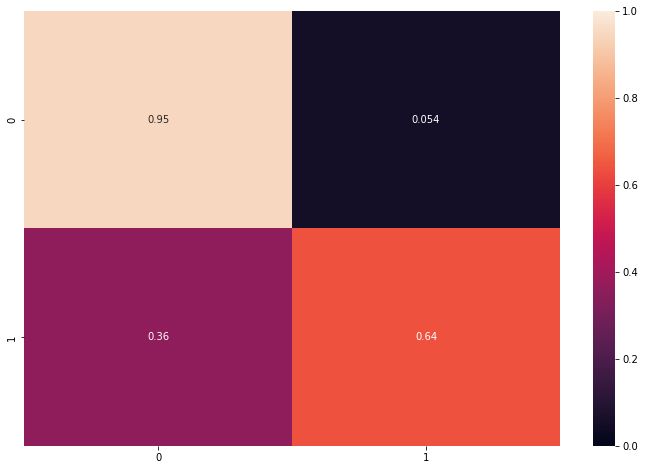

In [37]:
#Predict class using logits
y_pred = np.argmax(test_results.predictions, axis=-1)
#show the confusion matrix
plt.figure(figsize = (12,8))
sns.heatmap(confusion_matrix(test_results.label_ids, y_pred, normalize='true'),vmin=0.0, vmax=1.0, annot=True);
#show classification report
print(classification_report(test_results.label_ids, y_pred, digits=4))